<a href="https://colab.research.google.com/github/AyushCodez/SpeechEmotion/blob/main/text_generation/classifier/emotion_classifier_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
from transformers import pipeline
#from utils import emotion_classifier, emotion_classifier2, EmoAccuracyrequired

EmoAccuracyrequired = 0.2


emotion_classifier ="j-hartmann/emotion-english-distilroberta-base"


def getclassifier():
    classifier = pipeline("text-classification", model = emotion_classifier, return_all_scores=True)
    return classifier

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    classifier = getclassifier()

In [ ]:

#implementing two ways to run the classifier model

# 1) check the emotion/tone of the paragraph as a whole
def check_possible_emotions_aswhole(text):
    result = classifier(text)[0]
    possible_emotions = {}
    for emotion in result:
        if(emotion['score']>EmoAccuracyrequired):
            possible_emotions[emotion['label']] = emotion['score']
    return possible_emotions


# 2) check the emotions/tone of the para line by line
def check_possible_emotions_linebyline(text):
    emo = {'fear':0.0, 'anger':0.0, 'joy':0.0, 'sadness':0.0, 'surprise':0.0, 'neutral':0.0, 'disgust':0.0}
    lines = text.split(".")
    for line in lines:
        result = classifier(line)[0]
        for emotion in result:
            emo[emotion['label']] += emotion['score']
    n = len(lines)
    possible_emo = {}
    for label in emo:
        emo[label] = emo[label]/n
        if(emo[label]>EmoAccuracyrequired):
            possible_emo[label] = emo[label]
    return possible_emo

In [ ]:
#imports to plot a confusion matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, plotname, figsize=(5, 5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'By LLM'
    cm.columns.name = 'Predicted by classifier'
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(plotname)
    sns.heatmap(cm, cmap="YlGnBu", annot=annot, fmt='', ax=ax, vmax=30)


1   neutral  --->  {'fear': 0.9771004915237427}
2   joy  --->  {'neutral': 0.31524986028671265}
3   sadness  --->  {'fear': 0.9497121572494507}
4   anger  --->  {'fear': 0.2836771309375763, 'neutral': 0.30044347047805786}
5   fear  --->  {'fear': 0.9700117111206055}
6   surprise  --->  {'fear': 0.7386080026626587}
7   disgust  --->  {'sadness': 0.8514746427536011}
8   neutral  --->  {'joy': 0.8644605875015259}
9   joy  --->  {'joy': 0.9626445770263672}
10   sadness  --->  {'joy': 0.49365440011024475, 'neutral': 0.43478018045425415}
11   anger  --->  {'anger': 0.5315966606140137, 'fear': 0.4445735216140747}
12   fear  --->  {'neutral': 0.8784145712852478}
13   surprise  --->  {'fear': 0.9598203301429749}
14   disgust  --->  {'disgust': 0.9833613038063049}
15   neutral  --->  {'fear': 0.8816993832588196}
16   neutral  --->  {'fear': 0.3249273896217346, 'joy': 0.36902961134910583}
17   joy  --->  {'joy': 0.9524880647659302}
18   sadness  --->  {'sadness': 0.8448439240455627}
19   anger  -

<ipython-input-42-1a2e4f2baa31>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


0.6679841897233202

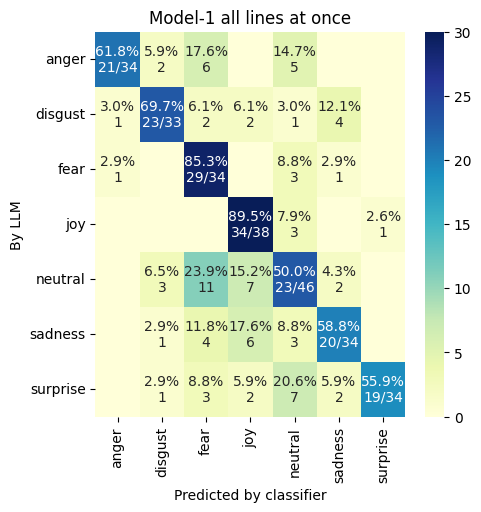

In [ ]:
# 1) Way-1 to do things

sentences = open("/content/responses.txt", "r").read()
sentences = sentences.split("\n\n")

#print(sentences)

y_true = []
y_pred = []
c=1;

for sentence in sentences:
    emotion = sentence.split("]")[0][1:]
    line = sentence.split("]")[1]
    possible_emo = check_possible_emotions_aswhole(line)
    emotion = emotion.lower()
    if(emotion=='sad'):
      emotion='sadness'
    #print(emotion, " --> ", possible_emo)
    y_true.append(emotion)
    if emotion in possible_emo:
        y_pred.append(emotion)
    else:
        y_pred.append(max(possible_emo, key=possible_emo.get))
    print(c, " ", emotion, " ---> ", possible_emo)
    c+=1
plot_cm(y_true, y_pred, "Model-1 all lines at once")

cnt = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
        cnt += 1
Accuracy = cnt / len(y_true)
Accuracy


neutral  --->  {'fear': 0.5177288216849169}
joy  --->  {'neutral': 0.3748224824666977}
sadness  --->  {'fear': 0.630548016478618, 'neutral': 0.20450994527588287}
anger  --->  {'neutral': 0.4334307760000229}
fear  --->  {'fear': 0.5170904342085123, 'neutral': 0.27837967802770436}
surprise  --->  {'fear': 0.3498793343702952, 'neutral': 0.3044135657449563}
disgust  --->  {'anger': 0.29803580914934474, 'sadness': 0.33694869590302307}
neutral  --->  {'joy': 0.5317979951699575, 'neutral': 0.2688395281632741}
joy  --->  {'joy': 0.4845721224943797, 'neutral': 0.33437078694502514}
sadness  --->  {'neutral': 0.596280574798584}
anger  --->  {'fear': 0.37800172592202824, 'neutral': 0.34382018462444347}
fear  --->  {'neutral': 0.7806762059529623}
surprise  --->  {'fear': 0.6484456025063992}
disgust  --->  {'fear': 0.2740695277073731, 'neutral': 0.2437641064170748, 'disgust': 0.35824476058284443}
neutral  --->  {'fear': 0.7213047742843628}
neutral  --->  {'fear': 0.22247321344912052, 'joy': 0.205491

<ipython-input-42-1a2e4f2baa31>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


0.7075098814229249

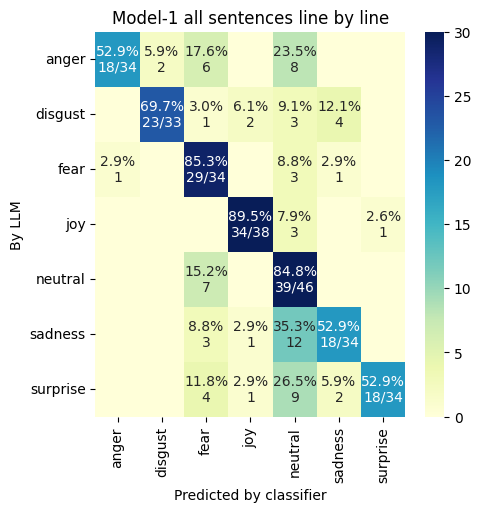

In [ ]:
# 2) Way-2 to do things

sentences = open("/content/responses.txt", "r").read()
sentences = sentences.split("\n\n")

#print(sentences)

y_true = []
y_pred = []

for sentence in sentences:
    emotion = sentence.split("]")[0][1:]
    line = sentence.split("]")[1]
    possible_emo = check_possible_emotions_linebyline(line)
    emotion = emotion.lower()
    if(emotion=='sad'):
      emotion='sadness'
    #print(emotion, " --> ", possible_emo)
    y_true.append(emotion)
    if emotion in possible_emo:
        y_pred.append(emotion)
    else:
        y_pred.append(max(possible_emo, key=possible_emo.get))
    print(emotion, " ---> ", possible_emo)

print(y_true)
print(y_pred)
print(y_true.count('neutral'))
plot_cm(y_true, y_pred, "Model-1 all sentences line by line")
#plot_cm(y_pred, y_true)

cnt = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
        cnt += 1
Accuracy = cnt / len(y_true)
Accuracy